In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from aging.plotting import format_plots, figure, legend, save_factory, PlotConfig
from sklearn.decomposition import NMF
from tqdm.auto import tqdm
import colorcet as cc

In [11]:
c = PlotConfig()
format_plots()
saver = save_factory(c.save_path / "dynamics-of-aging", tight_layout=False)

In [12]:
def load_long_df(version=5):
    usage_mtx = pd.read_parquet(
        f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/longtogeny_males_clean.parquet"
    )
    return usage_mtx

In [13]:
df = load_long_df(version=5)
# df = df[df.index.get_level_values('age') < 600]
n_bins = 35
bins = pd.qcut(df.index.get_level_values('age'), n_bins, labels=False)
df['binned_age'] = bins

In [14]:
age_map = np.floor(df.reset_index().groupby('binned_age')['age'].mean())

In [15]:
new_grouping = df.groupby(['mouse', 'binned_age']).mean()

## Resample mice to get some errorbars on NMF components

In [16]:
mice = df.index.levels[1]

In [17]:
n_mice = 13
n_shuffs = 250
n_components = 3

np.random.seed(0)

components = []
scores = []
for i in tqdm(range(n_shuffs)):
    choices = np.random.choice(mice, size=n_mice, replace=False)

    agg = []
    for mouse, x in new_grouping.loc[choices].groupby('mouse'):
        x = x.droplevel(0).reindex(np.arange(n_bins), fill_value=0)
        x.index = pd.MultiIndex.from_arrays([pd.Index([mouse] * len(x), name='mouse'), x.index])
        agg.append(x)
    agg = pd.concat(agg)

    arr = np.array([x.to_numpy() for _, x in agg.groupby('mouse')])

    in_data = np.concatenate(arr, axis=1).T

    nmf = NMF(n_components=n_components, max_iter=750, random_state=0)
    nmf.fit(in_data)
    components.append(nmf.components_.T)

    # get syllable scores
    out = nmf.transform(in_data)
    avg_scores = out.reshape(len(arr), 57, 3).mean(0)
    scores.append(avg_scores)

component_df = []
scores_df = []
for i, comp in enumerate(components):
    _df = pd.DataFrame(comp)
    _df['iteration'] = i
    component_df.append(_df)
    _df = pd.DataFrame(scores[i])
    _df['iteration'] = i
    scores_df.append(_df)
component_df = pd.concat(component_df)
scores_df = pd.concat(scores_df)

  0%|          | 0/250 [00:00<?, ?it/s]

In [18]:
to_plt = component_df.reset_index().melt(id_vars=['iteration', 'index'])
to_plt['age'] = to_plt['index'].map(age_map) / 7

In [19]:
to_plt

,iteration,index,variable,value,age
0,0,0,0,0.000000,3.000000
1,0,1,0,0.029643,3.428571
2,0,2,0,0.046036,3.714286
3,0,3,0,0.097753,4.000000
4,0,4,0,0.238065,4.428571
...,...,...,...,...,...
26245,249,30,2,0.462611,62.000000
26246,249,31,2,0.482235,64.857143
26247,249,32,2,0.432891,68.285714
26248,249,33,2,0.450044,93.285714


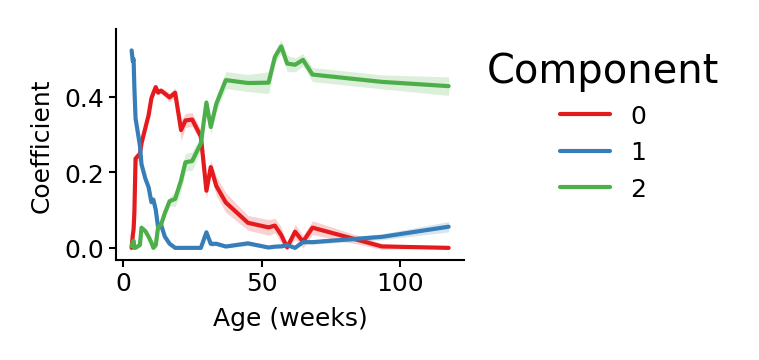

In [20]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=to_plt,
    x="age",
    y="value",
    hue="variable",
    errorbar="sd",
    palette="Set1",
    err_kws=dict(lw=0),
)
ax.set(ylim=(None, None), xlabel="Age (weeks)", ylabel="Coefficient")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-components");

In [15]:
to_plt = scores_df.reset_index().melt(id_vars=['iteration', 'index'])

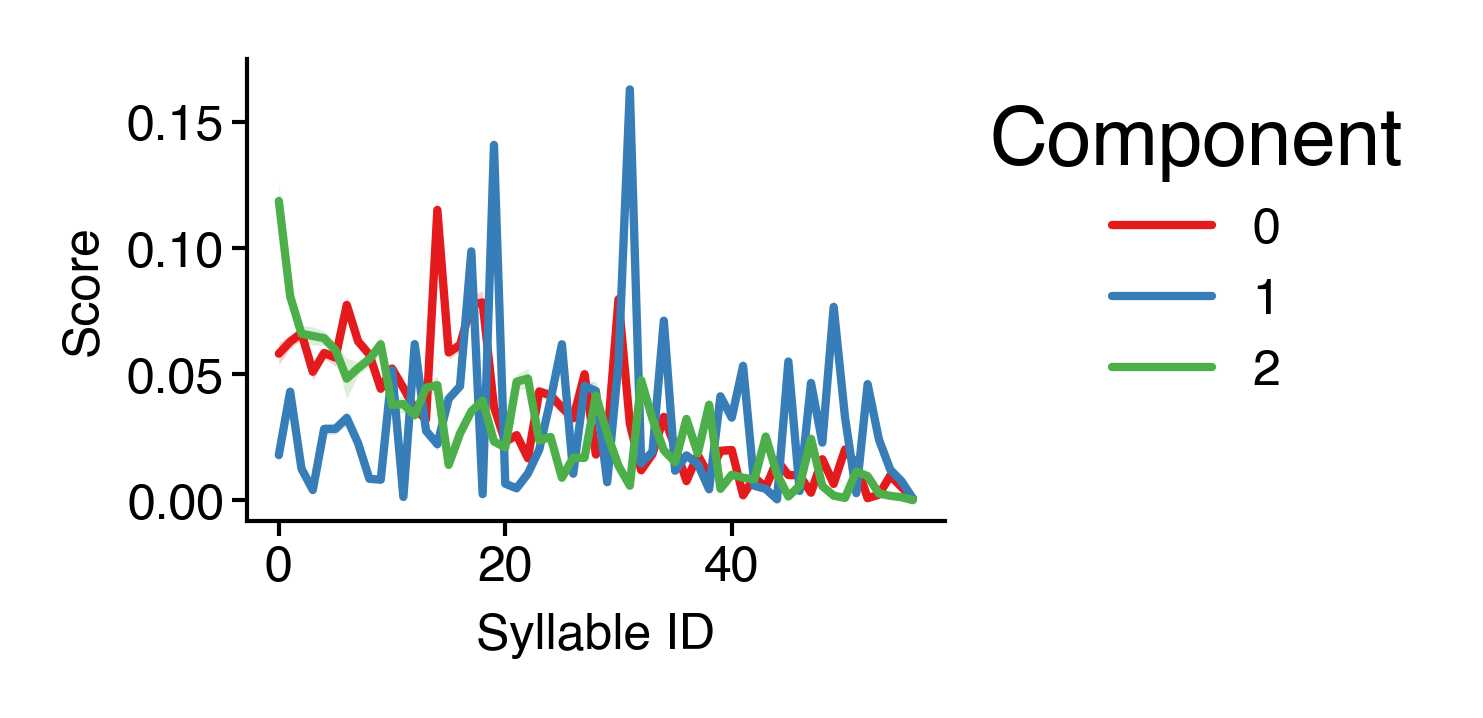

In [17]:
fig = figure(1.5, 1)
ax = sns.lineplot(
    data=to_plt,
    x="index",
    y="value",
    hue="variable",
    errorbar="sd",
    palette="Set1",
    err_kws=dict(lw=0),
)
ax.set(ylim=(None, None), xlabel="Syllable ID", ylabel="Score")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-scores");

In [11]:
nmf.components_.shape

(3, 35)

In [15]:
out = nmf.transform(in_data)
out.shape

(741, 3)

In [27]:
arr.shape

(13, 35, 57)

In [28]:
reshaped = out.reshape(len(arr), 57, 3)

In [ ]:
scores_df = pd.DataFrame(out)
scores_df['syllable'] = np.tile(np.arange(57), 13)
scores_df = scores_df.melt(id_vars='syllable', var_name='component', value_name='score')

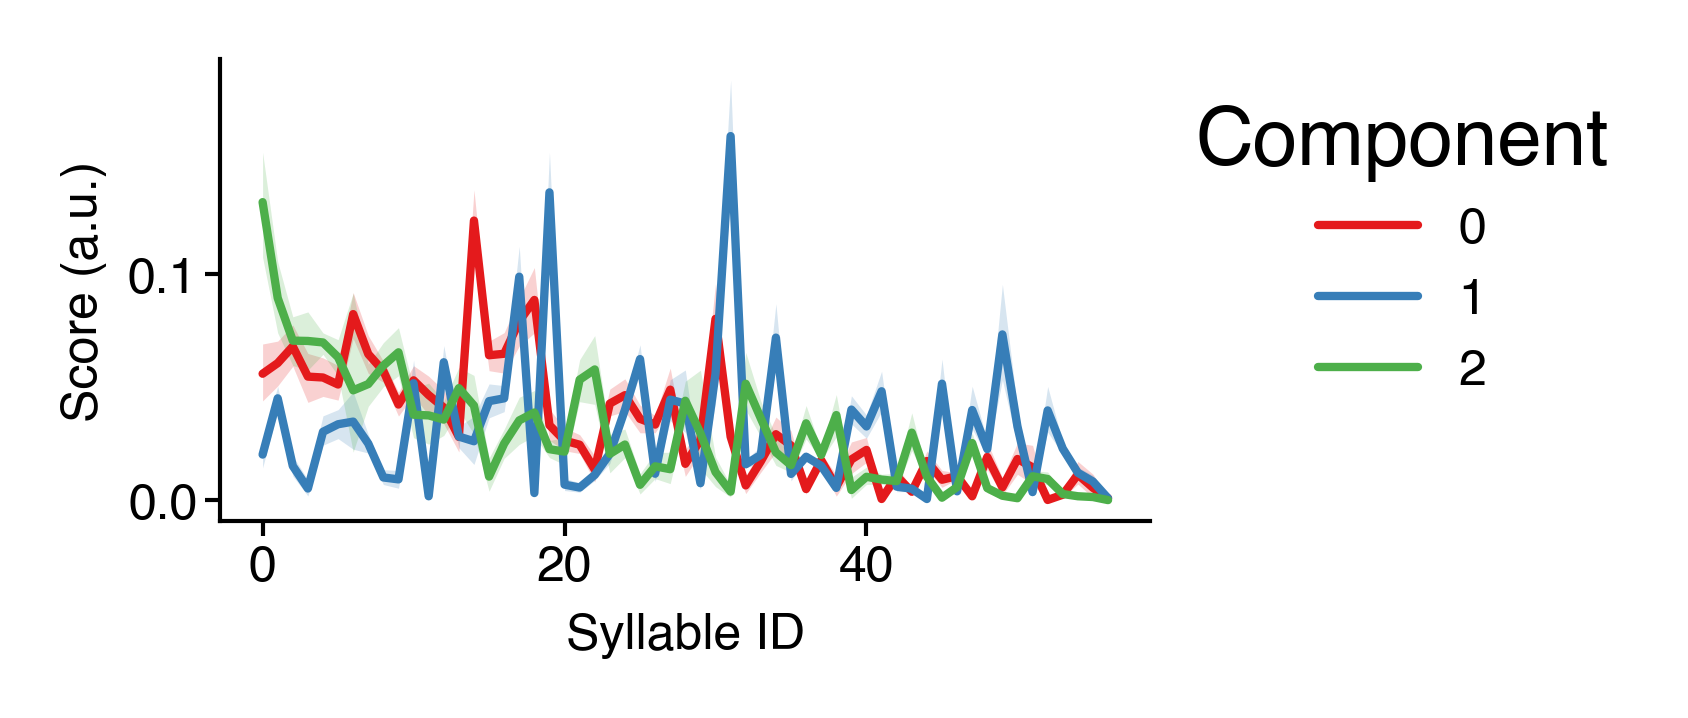

In [43]:
fig = figure(2, 1)
ax = sns.lineplot(
    data=scores_df,
    x="syllable",
    y="score",
    hue="component",
    errorbar=("ci", 95),
    palette="Set1",
    err_kws=dict(lw=0),
    lw=1
)
ax.set(xlabel="Syllable ID", ylabel="Score (a.u.)")
legend(ax, title="Component")
sns.despine()
saver(fig, "nmf-scores");